<a href="https://colab.research.google.com/github/xrysav31/MPA-MLF/blob/main/Miniproject/Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF - Miniproject

## Data examination

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install kneed

In [43]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

## Data preprocessing

In [44]:
loaded_points = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_prepared_final/Data_prepared_final.csv')
loaded_points = loaded_points.drop(columns=['Unnamed: 0','time [s]'])

In [45]:
points=np.asarray(loaded_points)
loaded_points.head()

,cfo_meas,cfo_demod,gain_imb,iq_imb,or_off,quadr_err,ph_err,mag_err,evm
0,-414,-421.076324,0.076097,-46.987598,-27.219631,0.104362,1.129778,0.440299,2.059935
1,-414,-423.571686,0.069879,-47.852627,-26.934967,0.053158,1.050010,0.431240,1.815053
2,-414,-421.033936,0.061466,-48.968697,-27.130722,-0.045913,0.989473,0.447790,1.762053
3,-414,-420.103546,0.078836,-46.756973,-27.005318,0.081583,1.085091,0.443476,1.894204
4,-432,-420.781097,0.066053,-47.048218,-27.358521,0.081920,1.023701,0.465225,1.805841


In [46]:
scaler = StandardScaler()
points = scaler.fit_transform(points)

## Model building and model training

### Build the model and fit it to the data

In [47]:
def initialize_clusters(points: np.array, k_clusters: int) -> np.array:
    index = np.arange(points.shape[0])
    np.random.shuffle(index)
    req_index = index[:k_clusters]
    m_points = points[req_index]
    return m_points

In [48]:
def calculate_metric(points: np.array, centroid: np.array) -> np.array:
    metric = np.square(np.linalg.norm(points-centroid, axis=1))
    return metric

In [49]:
def compute_distances(points: np.array, centroids_points: np.array) -> np.array:
    distance = np.asarray([calculate_metric(points, centroid) for centroid in centroids_points])
    return distance

In [50]:
def assign_centroids(distances: np.array) -> np.array:
    assigned_centroids = np.argmin(distances, axis=0)
    return assigned_centroids

In [51]:
def calculate_objective(cluster_belongs: np.array, distances: np.array) -> np.array:
    sum_objective = np.sum(distances.T[np.arange(len(distances.T)), cluster_belongs])
    return sum_objective

In [52]:
def calculate_new_centroids(points: np.array, clusters_belongs: np.array, n_of_clusters: int) -> np.array:
    new_clusters = []
    for cluster_id in range(n_of_clusters):
        j = np.where(clusters_belongs == cluster_id)
        points_sel = points[j]
        new_clusters.append(np.mean(points_sel, axis=0))
    return np.array(new_clusters)

In [53]:
def fit(points: np.array, n_of_centroids: int, n_of_oterations: int, error: float = 0.001) -> tuple:
    centroid_points = initialize_clusters(points, n_of_centroids)
    last_objective = 10000

    for _ in range(n_of_oterations):
        distance = compute_distances(points, centroid_points)
        cluster_belong = np.argmin(distance, axis=0)

        objective = calculate_objective(cluster_belong, distance)

        if abs(last_objective - objective) < error:
            break

        last_objective = objective
        centroid_points = calculate_new_centroids(points, cluster_belong, n_of_centroids)

    return centroid_points, last_objective

In [68]:
k_all = range(1, 80)
all_objective = []

for i in k_all:
    a, b = fit(points, i, 1000)
    all_objective.append(b)

In [69]:
kneedle = KneeLocator(k_all, all_objective,S=1, curve='convex', direction='decreasing')
print("Number of transmitters:",kneedle.knee)

Number of transmitters: 9


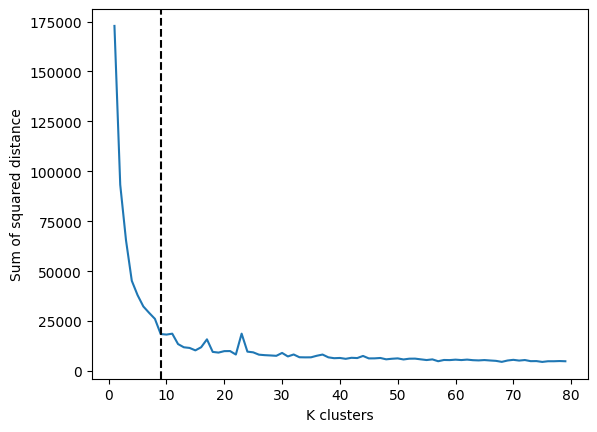

In [70]:
plt.figure()
plt.plot(k_all, all_objective)
plt.xlabel('K clusters')
plt.ylabel('Sum of squared distance')
plt.axvline(kneedle.knee, color='black', linestyle='--', label='Knee Point')